## data set の読み込み
- remote から取得する


In [11]:
!if [ -n akb.zip ]; then wget https://kokoichi0206.mydns.jp/data/saka/akb.zip; fi

--2022-04-16 19:21:27--  https://kokoichi0206.mydns.jp/data/saka/akb.zip
Resolving kokoichi0206.mydns.jp (kokoichi0206.mydns.jp)... 119.106.0.95, 240f:74:c9f6:1:dea6:32ff:feb4:6b83
Connecting to kokoichi0206.mydns.jp (kokoichi0206.mydns.jp)|119.106.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 319420982 (305M) [application/zip]
Saving to: ‘akb.zip’

akb.zip             100%[===================>] 304.62M  10.9MB/s    in 29s     

2022-04-16 19:21:58 (10.3 MB/s) - ‘akb.zip’ saved [319420982/319420982]



In [12]:
!if [ -n saka.zip ]; then wget https://kokoichi0206.mydns.jp/data/saka/saka.zip; fi

--2022-04-16 19:21:58--  https://kokoichi0206.mydns.jp/data/saka/saka.zip
Resolving kokoichi0206.mydns.jp (kokoichi0206.mydns.jp)... 119.106.0.95, 240f:74:c9f6:1:dea6:32ff:feb4:6b83
Connecting to kokoichi0206.mydns.jp (kokoichi0206.mydns.jp)|119.106.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 251371198 (240M) [application/zip]
Saving to: ‘saka.zip’

saka.zip            100%[===================>] 239.73M  10.7MB/s    in 24s     

2022-04-16 19:22:23 (10.0 MB/s) - ‘saka.zip’ saved [251371198/251371198]



In [17]:
!if [ -n akb.zip ]; then yes | unzip akb.zip >/dev/null; fi
!if [ -n akb.zip ]; then yes | unzip saka.zip >/dev/null; fi

In [14]:
!ls

akb.zip  saka.zip  sample_data


In [15]:
import glob
import gc
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as layers


In [18]:
groups = ["akb", "saka"]

akbs = glob.glob("akb/*/*.jpg")
sakas = glob.glob("saka/*/*.jpg")
faces = []

print(np.asarray(Image.open(akbs[0]), np.uint8).shape)


for path in akbs:
    with Image.open(path) as img:
        # colabでリサイズする場合
        img = img.resize((64, 64), Image.LANCZOS)
        faces.append(np.asarray(img, np.uint8))

for path in sakas:
    with Image.open(path) as img:
        img = img.resize((64, 64), Image.LANCZOS)
        faces.append(np.asarray(img, np.uint8))

X = np.array(faces)
# 正解ラベルを作成する
len_akbs = len(akbs)
len_sakas = len(sakas)
a = np.zeros((len_akbs, 1), dtype="float32")
s = np.ones((len_sakas, 1), dtype="float32")
y = np.concatenate([a, s])

(512, 512, 3)


In [19]:
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [20]:
print(X.shape)
print(y.shape)
print(X.shape[1])

(10193, 64, 64, 3)
(10193, 1)
64


## model の作成・訓練

In [22]:
import tensorflow.keras as keras

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.05),
    ]
)

In [33]:
IMG_SIZE = X.shape[1]
inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
# x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 3)    0           ['input_7[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 60, 60, 32)   2400        ['sequential[6][0]']             
                                                                                                  
 batch_normalization_43 (BatchN  (None, 60, 60, 32)  128         ['conv2d_9[0][0]']               
 ormalization)                                                                              

In [24]:
def create_dataset(X, y, test_size=0.1, val_size=0.2, random_state=123):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=round(val_size/(1-test_size), 2), random_state=random_state)

    return X_train.astype(np.float32) / 255.0, X_test.astype(np.float32) / 255.0, X_val.astype(np.float32) / 255.0, \
            y_train.astype(np.float32), y_test.astype(np.float32), y_val.astype(np.float32)

In [34]:
import tensorflow.keras as keras

model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32
epochs = 150

X_train, X_test, X_val, y_train, y_test, y_val = create_dataset(X, y)

checkpoint_filepath = "checkpoint_filepath.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_best_only=True,
                                    monitor="val_loss")
]

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    callbacks=callbacks)



Epoch 1/150
224/224 [==============================] - 16s 56ms/step - loss: 0.6917 - accuracy: 0.5816 - val_loss: 0.7018 - val_accuracy: 0.4383
Epoch 2/150
224/224 [==============================] - 12s 53ms/step - loss: 0.6324 - accuracy: 0.6447 - val_loss: 0.6574 - val_accuracy: 0.5651
Epoch 3/150
224/224 [==============================] - 12s 53ms/step - loss: 0.6012 - accuracy: 0.6757 - val_loss: 0.9331 - val_accuracy: 0.5750
Epoch 4/150
224/224 [==============================] - 12s 52ms/step - loss: 0.5845 - accuracy: 0.6923 - val_loss: 1.1723 - val_accuracy: 0.5830
Epoch 5/150
224/224 [==============================] - 12s 53ms/step - loss: 0.5672 - accuracy: 0.7074 - val_loss: 0.6060 - val_accuracy: 0.6701
Epoch 6/150
224/224 [==============================] - 12s 53ms/step - loss: 0.5485 - accuracy: 0.7218 - val_loss: 0.5635 - val_accuracy: 0.7103
Epoch 7/150
224/224 [==============================] - 12s 53ms/step - loss: 0.5328 - accuracy: 0.7351 - val_loss: 0.6210 - val_ac

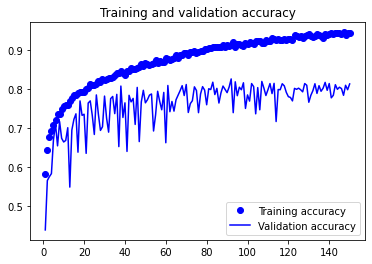

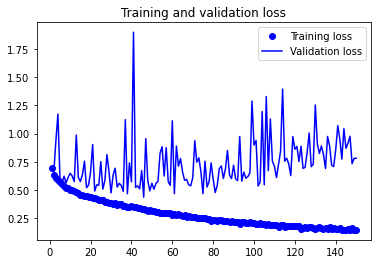

In [35]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [36]:
test_model = keras.models.load_model(checkpoint_filepath)
test_loss, test_acc = test_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 9ms/step - loss: 0.4415 - accuracy: 0.8059
Test accuracy: 0.806
